#Install dependecies, import libraries and get files from kaggle

In [3]:
!pip uninstall -y kaggle
!pip install kaggle

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp37-none-any.whl
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

#utilities
import kaggle
import os
import zipfile

#tensorflow
import tensorflow as tf

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [5]:
!mkdir cassava

In [6]:
!kaggle competitions download -p '/content/cassava' -c 'cassava-leaf-disease-classification' 

100% 5.75G/5.76G [02:10<00:00, 49.8MB/s]
100% 5.76G/5.76G [02:10<00:00, 47.3MB/s]


In [6]:
with zipfile.ZipFile('/content/cassava/cassava-leaf-disease-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/cassava_files')

In [7]:
base_path = '/content/cassava_files/'
images_path = '/content/cassava_files/train_images/'

os.listdir(base_path)

['train_tfrecords',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'test_images',
 'train.csv',
 'sample_submission.csv']

In [8]:
train = pd.read_csv(base_path + 'train.csv')

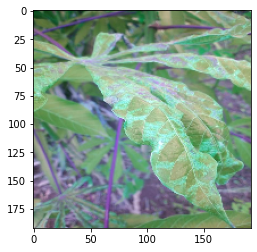

In [9]:
img_name = train['image_id'][1050]
img = cv2.imread(images_path + img_name)
img = cv2.resize(img, (192,192))
img = img/255
#img = img.astype(np.float16)
plt.imshow(img)


## Image Analysis

Create ranges to select pictures from each label

In [228]:
diseases = {
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}

In [238]:
images_path + train.loc[train['label'] == i, 'image_id'].sample(1).values[0]

'/content/cassava_files/train_images/1553432639.jpg'

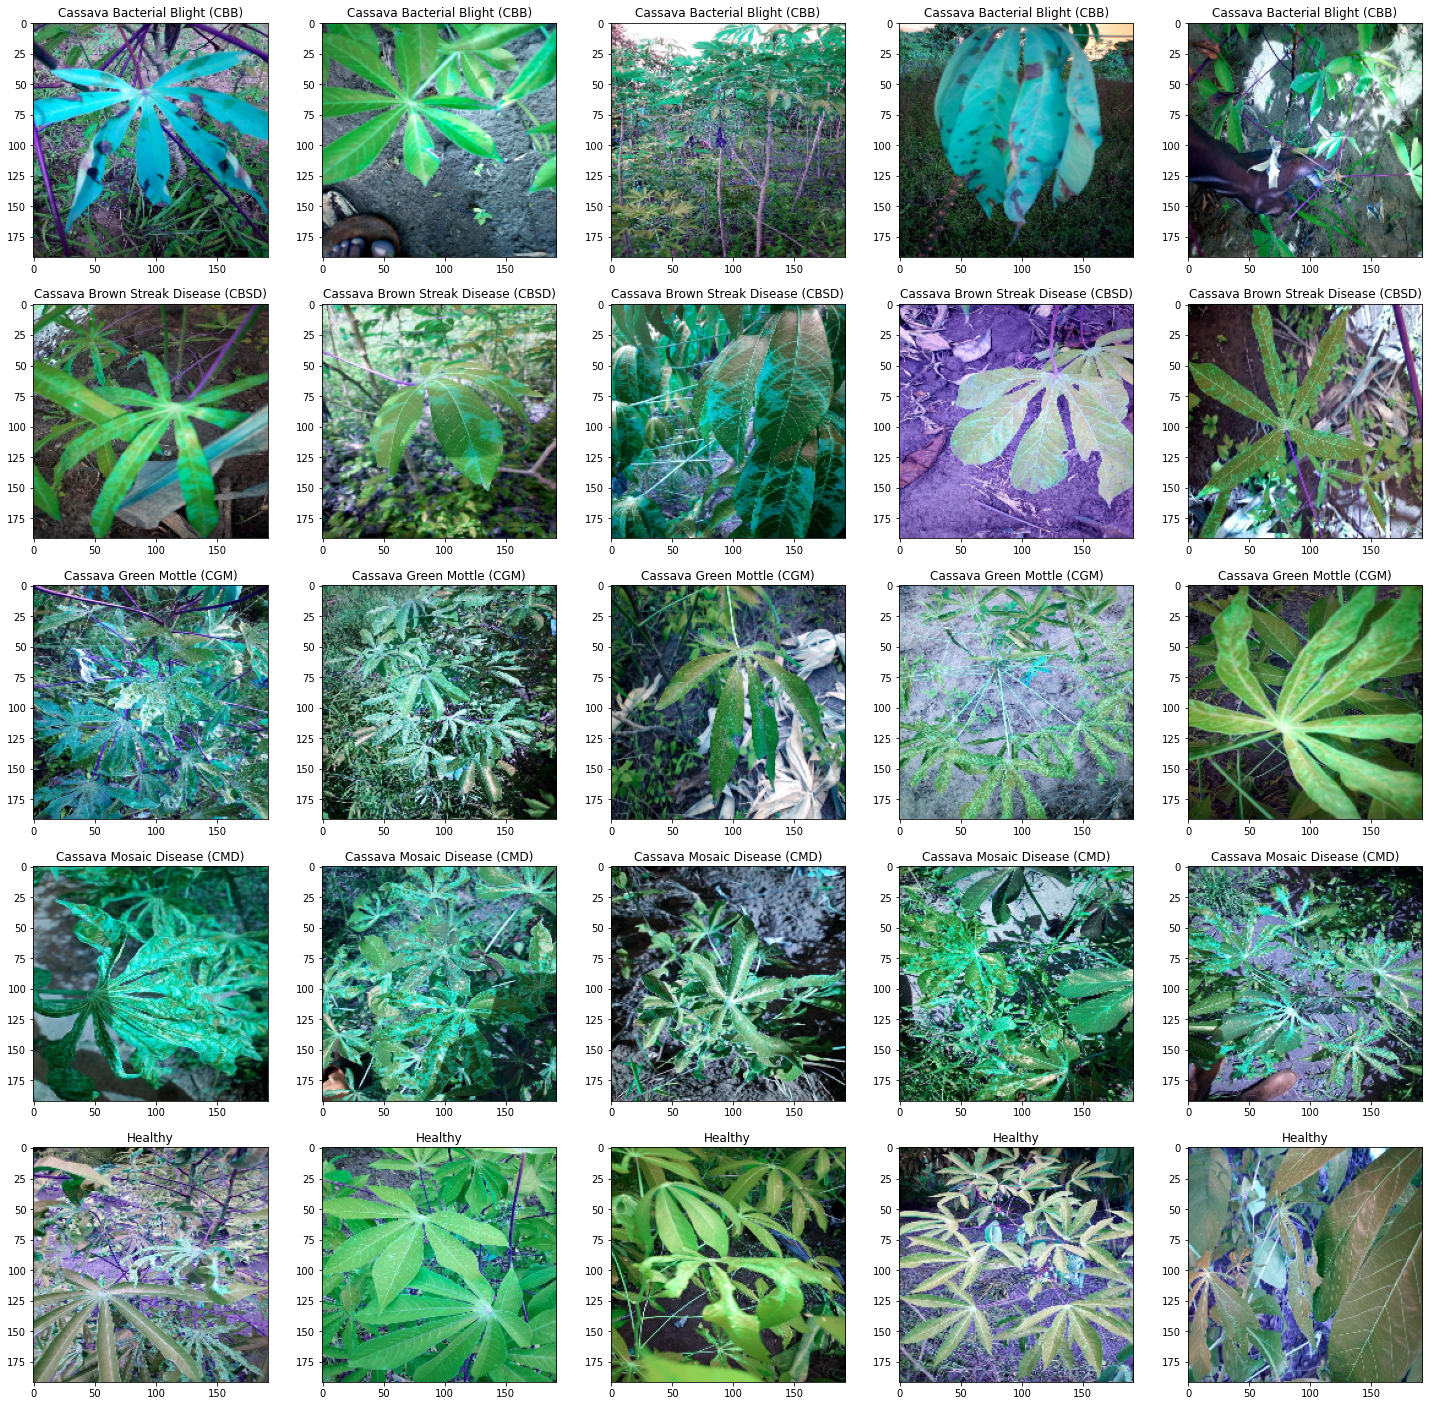

In [243]:
fig, ax = plt.subplots(nrows= 5, ncols=5, figsize =(25,25))
## label 
for axi, i in zip(ax.flat, sorted(5*groups) ) :

    img_name = train.loc[train['label'] == i, 'image_id'].sample(1).values[0]

    img = cv2.imread(images_path + img_name)
    img = cv2.resize(img, (192,192))
    axi.imshow(img)
    axi.set_title(diseases[str(i)])

In [109]:
#take a random integer on each range boundaries
random.randrange(*range_boudaries[0])

2

In [1]:
'''
def proprocessing_image(img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (256,256))
  img = img/255
  return img

In [21]:
'''
train['paths'] = train['image_id'].apply(lambda x: images_path + x) 
y = train['label'].values

train['images'] = train['paths'].map(lambda x : proprocessing_image(x))
'''

all_image_paths = [ images_path + train['image_id'][i] for i in range(len(train)) ]
y = train['label'].values

In [22]:
#Split images paths to train and set
X_train, X_test, y_train, y_test = train_test_split(all_image_paths, y, test_size = 0.2, stratify = y, random_state = 42)

In [23]:
tf_train_set = tf.data.Dataset.from_tensor_slices(X_train)
tf_test_set = tf.data.Dataset.from_tensor_slices(X_test)

In [24]:
# Preprocess images and data augmentation 
def load_and_preprocess_images(img):
  img = tf.io.read_file(img)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [192, 192])
  #img = tf.image.random_flip_left_right(img)
  #img = tf.image.random_contrast(img, 0.50, 0.90)
  img = img/255
  img = tf.cast(img, tf.float16)

  return img

In [25]:
# Apply function to the train and test
tf_train_set = tf_train_set.map(load_and_preprocess_images)
tf_test_set = tf_test_set.map(load_and_preprocess_images)
print( 'train : ', len(tf_train_set) )
print( 'test : ', len(tf_test_set) )

train :  17117
test :  4280


In [26]:
tf_train_labels = tf.data.Dataset.from_tensor_slices(y_train)
tf_test_labels = tf.data.Dataset.from_tensor_slices(y_test)

In [27]:
# Create a full dataset 
ds_train = tf.data.Dataset.zip((tf_train_set, tf_train_labels))
ds_test = tf.data.Dataset.zip((tf_test_set, tf_test_labels))

In [28]:
for img, label in ds_train.take(1):
  img_input_shape = list(img.shape)

In [29]:
#Shuffle and batch
batch_size = 16
train_len = len(tf_train_set)
test_len = len(tf_test_set)

ds_train = ds_train.shuffle(train_len).batch(batch_size)
ds_test = ds_test.shuffle(test_len).batch(batch_size)

In [19]:
num_labels = train['label'].nunique()
num_labels

5

In [27]:
# Création d'un model 
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape= img_input_shape),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(units=32, activation ="relu"),
    tf.keras.layers.Dense(units=16, activation ="relu"),
    tf.keras.layers.Dense(units=8, activation ="relu"),
    tf.keras.layers.Dense(units = num_labels, activation='softmax')
])


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                8388672   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [29]:
# Create a schedule learning rate 
initial_learning_rate = 0.00005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=500,
    decay_rate=0.96,
    staircase=True)

# Création d'un compileur
model.compile(optimizer = tf.keras.optimizers.Adam(lr_schedule),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

In [30]:
class_weights_values = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)


In [31]:
class_weight = {np.unique(y_train)[i]: class_weights_values[i] for i in range(num_labels) }

In [32]:
class_weight

{0: 3.934942528735632,
 1: 1.9551113649343232,
 2: 1.7932949188056575,
 3: 0.3252327569827095,
 4: 1.6610383309073264}

In [33]:
model.fit(ds_train,
          epochs=10,
          validation_data = ds_test,
          class_weight = class_weight
          )

Epoch 1/10
1070/1070 [==============================] - 176s 49ms/step - loss: 1.5922 - sparse_categorical_accuracy: 0.1881 - val_loss: 1.3296 - val_sparse_categorical_accuracy: 0.5269
Epoch 2/10
1070/1070 [==============================] - 142s 46ms/step - loss: 1.3924 - sparse_categorical_accuracy: 0.4297 - val_loss: 1.2179 - val_sparse_categorical_accuracy: 0.5806
Epoch 3/10
1070/1070 [==============================] - 142s 46ms/step - loss: 1.2852 - sparse_categorical_accuracy: 0.4865 - val_loss: 1.5687 - val_sparse_categorical_accuracy: 0.2764
Epoch 4/10
1070/1070 [==============================] - 142s 46ms/step - loss: 1.1489 - sparse_categorical_accuracy: 0.5538 - val_loss: 1.1511 - val_sparse_categorical_accuracy: 0.5624
Epoch 5/10
1070/1070 [==============================] - 142s 46ms/step - loss: 0.9735 - sparse_categorical_accuracy: 0.6286 - val_loss: 1.3166 - val_sparse_categorical_accuracy: 0.4998
Epoch 6/10


KeyboardInterrupt: ignored